<a href="https://colab.research.google.com/github/Twixx10/MachineLearningTASK/blob/main/Week7/01XGBoost_data_melb_M_Rakan_Bagus_1103213162.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learn on how to build and optimize model with **gradient boosting.**

#Introduction
By definition, **ensemble methods** combine the predictions of several models (e.g., several trees, in the case of random forest).

Now, we'll learn about another ensemble method called gradient boosting.

#Difference of Decision Tree, Random Forest, and XGBoost

1. Decision Tree:
A decision tree is a simple and interpretable model that recursively splits the data into subsets based on the feature values. It forms a tree-like structure where each internal node represents a test on a feature, each branch represents the outcome of that test, and each leaf node represents the final prediction. The decision tree makes binary decisions at each node to split the data. It is prone to overfitting, especially when the tree becomes deep, capturing noise and leading to poor generalization on unseen data.

2. Random Forest:
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions through voting (for classification) or averaging (for regression). Each decision tree is trained on a random subset of the data (bootstrap sample) and a random subset of the features. This randomness reduces overfitting and increases the model's ability to generalize to new data.

3. XGBoost (Extreme Gradient Boosting):
XGBoost is an optimized implementation of the Gradient Boosting algorithm. It creates an ensemble of weak learners (usually shallow decision trees) sequentially, where each new model corrects the errors made by the previous one. XGBoost uses a gradient-based optimization algorithm to minimize a loss function while adding new trees to the ensemble. It also includes regularization terms to control overfitting and speed up the training process. XGBoost is known for its high performance, scalability, and efficiency, making it popular in various machine learning competitions and real-world applications.
**XGBoost** is an implementation of gradient boosting with several additional features focused on perfmance and speed. The final result of an XGBoost model is a weighted sum of the predictions made by all the individual trees in the sequence. The contribution of each tree is adjusted during training based on how well it reduces the overall error.


Note:

* Regularization (penyederhanaan): XGBoost introduces regularization terms to control overfitting during the training process. Regularization helps prevent the model from becoming too complex and ensures better generalization to unseen data.


#Gradient Boosting

**Gradient boosting** is a method that goes through cycles to iteratively add models into an ensemble (setelan).

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent (kemudian) additions to the ensemble will address those errors.)

Then, we start the cycle:
1. First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we **add the predictions from all models** in the ensemble.
2. These predictions are used to calculate a loss function (like mean squared error, for instance).
3. Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.
4. Finally, we add the new model to ensemble, and ...
5. Repeat!

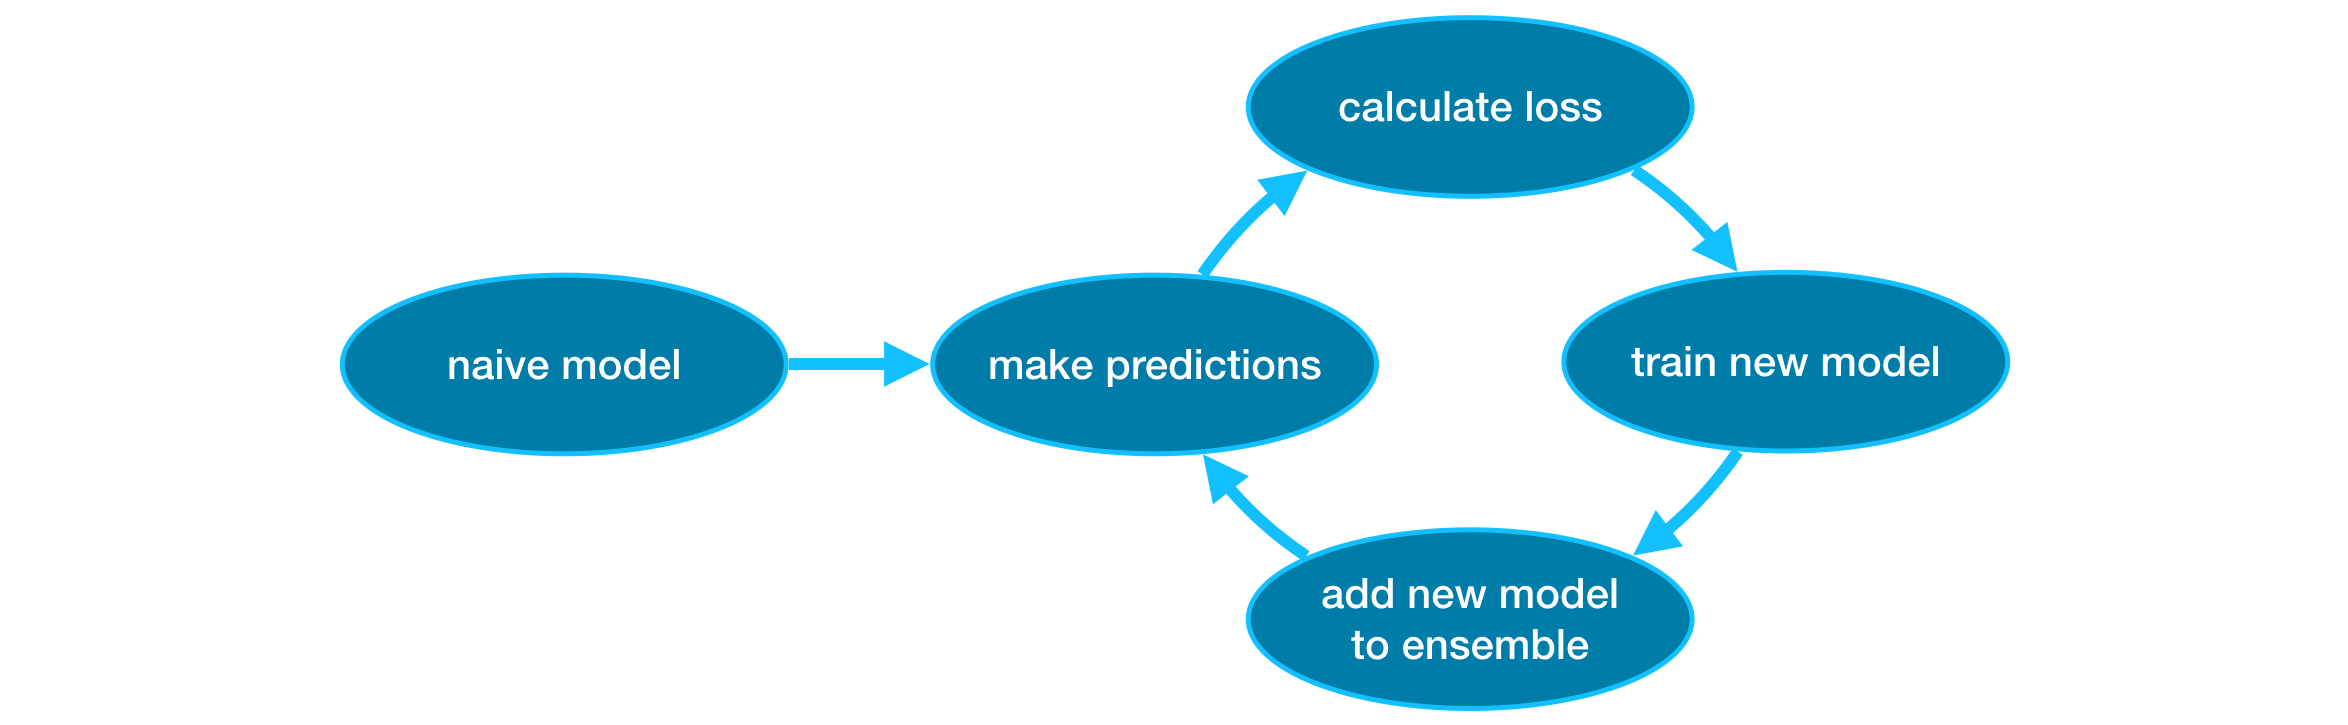

#Example
We begin by loading the training and validation data in X_train, X_valid, y_train, y_valid.

**Prompt:**

Write a code cell to mount Google Drive in Colab.

In [1]:
import pandas as pd  # Import library pandas untuk manipulasi data
from sklearn.model_selection import train_test_split  # Import fungsi untuk membagi dataset menjadi training dan validation set
from xgboost import XGBRegressor, plot_tree  # Import model XGBoost Regressor untuk regresi dan fungsi untuk plot tree
from sklearn.metrics import mean_absolute_error  # Import fungsi untuk menghitung Mean Absolute Error (MAE)
import matplotlib.pyplot as plt  # Import library matplotlib untuk visualisasi
from sklearn.model_selection import learning_curve  # Import fungsi untuk membuat learning curve
import numpy as np  # Import library numpy untuk perhitungan numerik
import shap  # Import library SHAP untuk interpretasi model
from sklearn.inspection import PartialDependenceDisplay  # Import fungsi untuk membuat Partial Dependence Plot



In [2]:
from google.colab import drive  # Import modul untuk mengakses Google Drive dari Google Colab
drive.mount('/content/drive')  # Mount Google Drive untuk mengakses file di dalamnya

Mounted at /content/drive


**Prompt:**

Write a code cell to read a CSV file from Google Drive into a DataFrame.

In [3]:
# Ganti 'your_file.csv' dengan path ke file yang ada di Google Drive
file_path = '/content/drive/MyDrive/Machine Learning/Dataset/melb_data.csv' # Menentukan path ke file CSV

# Membaca file CSV ke dalam DataFrame
data = pd.read_csv(file_path)

# Menampilkan beberapa baris pertama dari DataFrame untuk memastikan data sudah ter-load dengan benar
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


**Prompt:**

Write a code cell to select a subset of predictors ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt'] and set the target variable ['Price'] from the DataFrame.

In [4]:
# Menentukan predictor (fitur) dan target
predictors = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']  # Fitur yang digunakan untuk prediksi
X = data[predictors]  # Variabel input
y = data['Price']  # Variabel target (harga properti)


Penjelasan: Cell ini memilih fitur yang relevan dari dataset dan menetapkan target sebagai Price, yang akan kita prediksi.

**Prompt:**

Write a code cell to split the data into training and validation

In [5]:
# Membagi data menjadi data latih dan data validasi
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Menampilkan jumlah data di masing-masing set
print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data validasi:", X_valid.shape[0])


Jumlah data latih: 10864
Jumlah data validasi: 2716


Penjelasan: Cell ini membagi dataset menjadi data latih (80%) dan data validasi (20%) menggunakan train_test_split. Ini bertujuan untuk mengevaluasi performa model pada data yang belum pernah dilihat.

Insights: Output menampilkan jumlah data latih dan validasi, yang memastikan pemisahan data berhasil.

In the next code cell, we import the scikit-learn API for XGBoost (`xgboost.XGBRegressor`). As you'll see in the output, the `XGBRegressor` class has many tunable parameters.


**Prompt:**

Write a code cell to train the model using XGBoost, and print the mean absolute error on the validation set.

In [6]:
# Mendefinisikan dan melatih model XGBoost Regressor
model = XGBRegressor(random_state=0)  # Membuat model XGBoost Regressor dengan seed acak 0
model.fit(X_train, y_train)  # Melatih model dengan data training

# Melakukan prediksi pada validation set
y_pred = model.predict(X_valid)  # Menggunakan model untuk memprediksi data validasi

# Menghitung dan mencetak Mean Absolute Error (MAE) dari prediksi
mae = mean_absolute_error(y_valid, y_pred)  # Menghitung MAE antara nilai sebenarnya dan prediksi
print("Mean Absolute Error on validation set:", mae)  # Mencetak nilai MAE untuk validation set

Mean Absolute Error on validation set: 230850.8424498343



Insights dari Mean Absolute Error (MAE):

Mean Absolute Error (MAE) adalah metrik evaluasi yang menunjukkan rata-rata kesalahan absolut antara prediksi model dengan nilai sebenarnya. Dalam konteks ini, MAE menunjukkan seberapa jauh rata-rata prediksi harga properti yang dihasilkan oleh model XGBoost dari harga sebenarnya.

MAE yang Rendah: Jika nilai MAE kecil, berarti rata-rata kesalahan prediksi model cukup kecil, yang menunjukkan bahwa model mampu memprediksi harga properti dengan akurasi yang baik. MAE rendah adalah indikator bahwa model mampu memahami pola data dengan baik tanpa terlalu banyak kesalahan.

MAE yang Tinggi: Jika nilai MAE besar, berarti rata-rata kesalahan prediksi cukup tinggi. Ini bisa menandakan bahwa model masih belum optimal atau bahwa ada faktor lain yang mungkin tidak terwakili dalam data yang diberikan (misalnya, fitur yang kurang relevan atau data yang tidak mencukupi). MAE yang tinggi juga dapat mengindikasikan bahwa model mungkin mengalami underfitting atau overfitting.

Interpretasi Unit MAE: Karena MAE diukur dalam satuan yang sama dengan target variabel (yaitu, harga properti dalam satuan tertentu, misalnya rupiah), kita dapat langsung melihat rata-rata besarnya kesalahan prediksi. Misalnya, jika MAE = 50.000, ini berarti prediksi model rata-rata meleset sebesar 50.000 dari harga properti yang sebenarnya.

We also make predictions and evaluate the model.

#Parameter Tuning
XGBoost has a few parameters that can dramatically affect accuracy and training speed. The first parameters you should understand are:

`n_estimators`
Specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.
* Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
* Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000, though this depends a lot on the `learning_rate` parameter discussed below.

Here is the code to set the number of models in the ensemble:

**Prompt:**

Write a code cell to create another XGBRegressor with 500 estimators, train it, and print the mean absolute error on the validation set.

In [7]:
# Mendefinisikan model dengan 500 estimators
model_500 = XGBRegressor(n_estimators=500, random_state=0)  # Membuat model XGBoost Regressor dengan 500 estimator

# Melatih model dengan 500 estimators
model_500.fit(X_train, y_train)  # Melatih model dengan data training

# Melakukan prediksi pada validation set
y_pred_500 = model_500.predict(X_valid)  # Menggunakan model untuk memprediksi data validasi

# Menghitung dan mencetak Mean Absolute Error (MAE) dari model dengan 500 estimators
mae_500 = mean_absolute_error(y_valid, y_pred_500)  # Menghitung MAE antara nilai sebenarnya dan prediksi
print("Mean Absolute Error on validation set with 500 estimators:", mae_500)  # Mencetak nilai MAE untuk validation set dengan 500 estimator



Mean Absolute Error on validation set with 500 estimators: 243749.46732326952


Insight : nilai Mean Absolute Error (MAE) pada validation set menggunakan model XGBoost dengan 500 estimator adalah sekitar 243,749.47. Ini merupakan peningkatan dalam nilai kesalahan (MAE lebih tinggi) dibandingkan dengan model sebelumnya yang menggunakan default estimator (230,850.84).

The MAE result of the model with n_estimators set to 500 turned out to be greater than the default value of n_estimators, which is 100.

The MAE (Mean Absolute Error) of the model with an n_estimators value of 110 turns out to be smaller than the default n_estimators value of 100, as well as n_estimators with a value of 500.

`early_stopping_rounds`
offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stop improving, even if we aren't the hard stop for `n_estimators`. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration (keburukan) to allow before stopping. Setting `early_stopping_rounds=5` is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores. This is done by setting the `eval_set` parameter.

We can modify the example above to include early stopping.

---
Note:

* In the context of training machine learning models, "deteriorating" refers to a situation where the performance of the model on a validation dataset worsens over consecutive iterations during the training process. Typically, we monitor a metric (such as accuracy, mean squared error, etc.) on the validation dataset to evaluate the model's performance.

* In the given code, verbose=False is an argument passed to the fit method of the XGBRegressor model. Setting verbose to False means that during the training process, the model will not produce any output or progress messages. It will train silently without displaying information about each boosting round.

`n_jobs`

On larger datasets where runtime is a consideration, you can use parallelism to build your model faster. It's common to set the parameter `n_jobs` equal to the number of cores on your machine. On smaller datasets, this won't help.
The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the `fit` command.

Here's the modified example.

**Prompt:**

Write a code cell to train an XGBRegressor with a custom learning rate, 90 estimators, and early stopping rounds, and print the mean absolute error on the validation set.

In [8]:
# Define the model with a custom learning rate, 90 estimators, and early stopping
model_custom = XGBRegressor(n_estimators=90, learning_rate=0.05, early_stopping_rounds=10, random_state=0)

# Train the model with early stopping
model_custom.fit(X_train, y_train,
                 eval_set=[(X_valid, y_valid)],
                 verbose=False)  # Set verbose=True to view training progress

# Make predictions on the validation set
y_pred_custom = model_custom.predict(X_valid)

# Calculate and print the Mean Absolute Error (MAE)
mae_custom = mean_absolute_error(y_valid, y_pred_custom)
print("Mean Absolute Error on validation set with custom learning rate and 90 estimators:", mae_custom)


Mean Absolute Error on validation set with custom learning rate and 90 estimators: 248182.02224088734


Insights dari Model dengan Custom Learning Rate, 90 Estimators, dan Early Stopping:

Model Setup:

Pada bagian awal, kita mendefinisikan model XGBRegressor dengan parameter yang telah dikustomisasi:
n_estimators=90: Jumlah pohon keputusan yang digunakan dalam ensemble diatur menjadi 90. Jumlah pohon yang lebih sedikit cenderung mencegah overfitting, tetapi juga dapat menyebabkan model underfitting jika jumlahnya terlalu sedikit.
learning_rate=0.05: Nilai ini menentukan besarnya setiap langkah dalam proses pembelajaran. Dengan nilai yang rendah (0.05), model belajar dalam langkah-langkah yang lebih kecil, sehingga lebih berhati-hati dalam menyesuaikan setiap pohon. Hal ini cenderung meningkatkan akurasi model namun membutuhkan lebih banyak iterasi untuk konvergen.
early_stopping_rounds=10: Early stopping membantu menghentikan pelatihan jika tidak ada peningkatan kinerja pada set validasi dalam 10 iterasi berturut-turut, yang dapat mencegah overfitting pada data pelatihan. Ini sangat berguna dalam mengoptimalkan waktu pelatihan dan meningkatkan generalisasi model pada data baru.
Proses Pelatihan dengan Early Stopping:

Model dilatih menggunakan data pelatihan (X_train, y_train) dengan memantau kinerja pada data validasi (X_valid, y_valid). Jika kinerja tidak membaik dalam 10 iterasi berturut-turut, pelatihan akan berhenti lebih awal.
Parameter verbose=False digunakan untuk menyembunyikan output proses pelatihan. Jika diatur ke True, kita dapat melihat perkembangan model setiap iterasi, termasuk metrik kesalahan pada data validasi.
Prediksi pada Set Validasi:

Setelah pelatihan selesai, kita melakukan prediksi pada set validasi menggunakan model yang telah dilatih. Prediksi ini akan digunakan untuk mengevaluasi performa model pada data yang belum pernah dilihat sebelumnya.
Evaluasi dengan Mean Absolute Error (MAE):

Mean Absolute Error (MAE) dihitung sebagai metrik evaluasi. MAE menunjukkan rata-rata kesalahan absolut antara nilai prediksi dan nilai aktual. Metrik ini menunjukkan seberapa jauh prediksi model dari nilai sesungguhnya dalam satuan yang sama dengan target variabel (misalnya, harga properti dalam rupiah).
MAE yang Rendah: Jika MAE rendah, ini menunjukkan bahwa model memberikan prediksi yang cukup akurat terhadap data validasi.
MAE yang Tinggi: Jika MAE tinggi, maka model mungkin perlu lebih banyak penyesuaian, baik dari segi parameter atau mungkin ada informasi penting dalam data yang tidak terwakili dalam fitur saat ini.
Interpretasi Hasil MAE:

Nilai MAE dari Output: MAE yang tercetak pada output memberikan gambaran tentang performa model. Semakin kecil nilainya, semakin baik performa model dalam memprediksi harga properti di set validasi.
Jika nilai MAE hasil tuning ini lebih rendah dibanding model sebelumnya tanpa tuning, maka model ini dianggap lebih baik. Sebaliknya, jika tidak ada peningkatan yang signifikan, kita mungkin perlu melakukan lebih banyak tuning atau mempertimbangkan penambahan fitur lain dalam data.

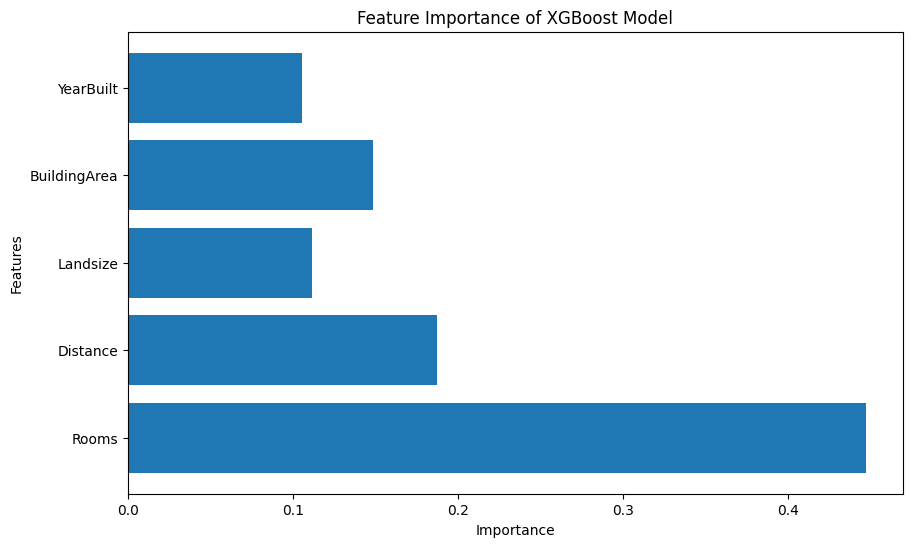

In [10]:
# Visualisasi Feature Importance
plt.figure(figsize=(10, 6))  # Mengatur ukuran figure
plt.barh(predictors, model.feature_importances_)  # Membuat bar chart horizontal dari feature importance
plt.xlabel('Importance')  # Memberi label pada sumbu x
plt.ylabel('Features')  # Memberi label pada sumbu y
plt.title('Feature Importance of XGBoost Model')  # Memberi judul pada plot
plt.show()  # Menampilkan plot

Insights: Fitur dengan nilai penting tinggi lebih berpengaruh terhadap prediksi. Ini berguna untuk interpretasi model.

Hasil dari kode ini adalah sebuah bar chart horizontal yang menunjukkan tingkat kepentingan dari setiap fitur dalam model XGBoost yang digunakan. Fitur dengan bar yang lebih panjang dianggap lebih penting dalam menentukan prediksi model. Visualisasi ini sangat berguna untuk memahami bagaimana model memprioritaskan fitur-fitur yang berbeda dan dapat membantu dalam proses interpretasi model serta pengambilan keputusan lebih lanjut dalam analisis data.

<Figure size 5000x10000 with 0 Axes>

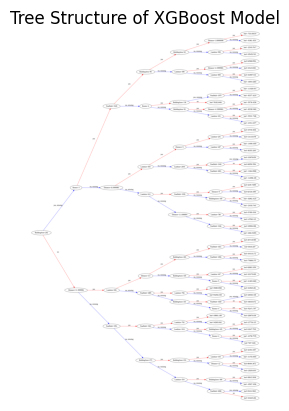

In [11]:
# Visualisasi Struktur Pohon
plt.figure(figsize=(50, 100))  # Mengatur ukuran figure
plot_tree(model, num_trees=2, rankdir='LR')  # Membuat visualisasi dari pohon pertama dalam model
plt.title('Tree Structure of XGBoost Model')  # Memberi judul pada plot
plt.show()  # Menampilkan plot

Hasil dari kode ini adalah visualisasi dari struktur pohon kedua dalam model XGBoost. Visualisasi ini akan menunjukkan bagaimana keputusan dibuat pada setiap node dalam pohon, termasuk fitur mana yang digunakan untuk membagi data dan nilai ambang batas yang digunakan. Ini sangat berguna untuk memahami bagaimana model XGBoost membuat prediksi dan dapat membantu dalam proses interpretasi model serta debugging. Visualisasi ini juga dapat membantu dalam menjelaskan model kepada orang lain yang mungkin tidak memiliki latar belakang teknis yang mendalam.

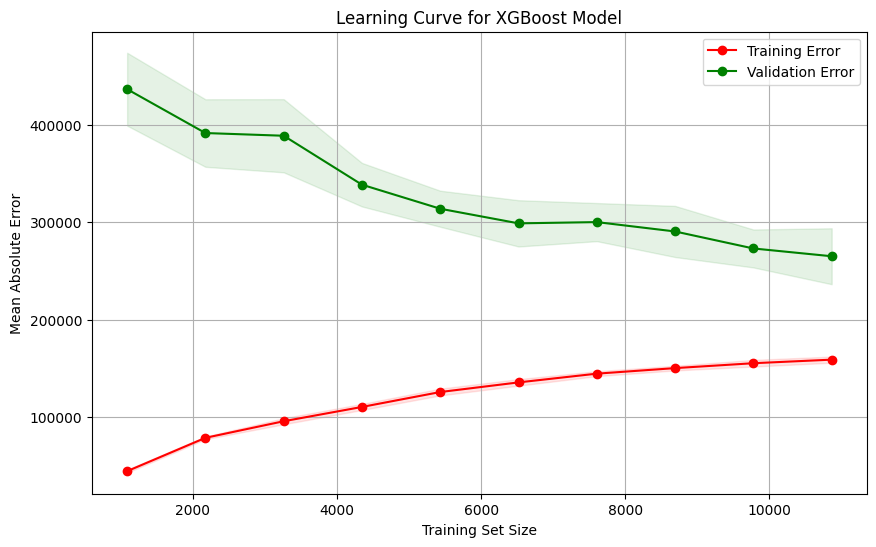

In [12]:
# Visualisasi Learning Curve
train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 10), random_state=0)

# Menghitung rata-rata dan standar deviasi dari train dan validation scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Validation Error')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve for XGBoost Model')
plt.legend(loc='best')
plt.grid()
plt.show()

Hasil dari kode ini adalah sebuah plot learning curve yang menunjukkan bagaimana performa model berubah dengan bertambahnya data pelatihan. Ini membantu dalam mengidentifikasi apakah model mengalami overfitting atau underfitting. Jika error validasi tinggi dan tidak menurun dengan bertambahnya data, model mungkin underfitting. Jika error pelatihan jauh lebih rendah daripada error validasi, model mungkin overfitting.
Penjelasan Kode SHAP Values

 98%|===================| 10604/10864 [00:37<00:00]       

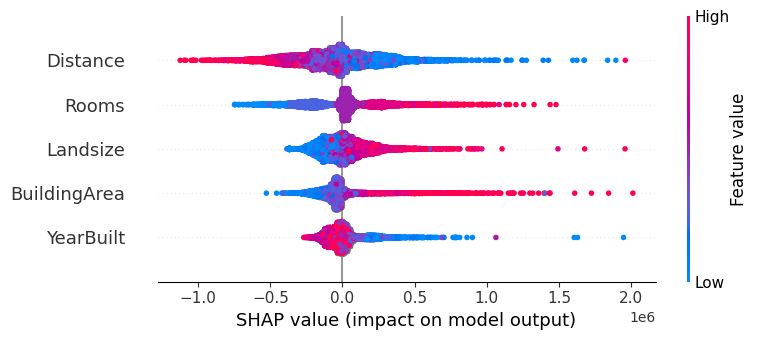

In [14]:
# Menghitung SHAP Values untuk interpretasi model
explainer = shap.Explainer(model, X_train)  # Membuat objek SHAP explainer
shap_values = explainer(X_train)  # Menghitung SHAP values untuk data validasi

# Visualisasi SHAP Summary Plot
shap.summary_plot(shap_values, X_train)  # Membuat summary plot dari SHAP values untuk melihat kontribusi fitur secara keseluruhan



Hasil dari kode ini adalah summary plot yang menunjukkan distribusi SHAP values untuk setiap fitur. Fitur dengan SHAP values yang lebih besar memiliki pengaruh lebih besar terhadap prediksi model. Plot ini membantu dalam memahami bagaimana setiap fitur mempengaruhi keputusan model, yang penting untuk interpretasi dan transparansi model.